# Hyperparameter Tuning And Regularization

We ended the last video with a classification accuracy of 77%. However, there are a few more nobs we can turn to improve the performance.

Our growing set of imports

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import scipy.stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

import activity_classifier_utils

## Load Data and Extract Features

In [2]:
fs = 256
data = activity_classifier_utils.LoadWristPPGDataset()
labels, subjects, features = activity_classifier_utils.GenerateFeatures(data,
                                                                        fs,
                                                                        window_length_s=10,
                                                                        window_shift_s=10)

## Hyperparameter Tuning

### Define hyperparameters

How many hyperparameters should we really use and how big should these trees be. At first we made our best guesses, but now we can explore this space and see if the performance changes.

In [3]:
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = range(2, 7)

In [4]:
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()
accuracy_table = []

In [5]:
import itertools

for n_estimators, max_tree_depth in itertools.product(n_estimators_opt, max_tree_depth_opt):
    # Iterate over each pair of hyperparameters
    cm = np.zeros((3, 3), dtype='int')                       # Create a new confusion matrix
    clf = RandomForestClassifier(n_estimators=n_estimators,  # and a new classifier  for each
                                 max_depth=max_tree_depth,   # pair of hyperparameters
                                 random_state=42,
                                 class_weight='balanced')
    for train_ind, test_ind in logo.split(features, labels, subjects):
        # Do leave-one-subject-out cross validation as before.
        X_train, y_train = features[train_ind], labels[train_ind]
        X_test, y_test = features[test_ind], labels[test_ind]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        c = confusion_matrix(y_test, y_pred, labels=class_names)
        cm += c
    # For each pair of hyperparameters, compute the classification accuracy
    classification_accuracy = np.sum(np.diag(cm)) / np.sum(np.sum(cm))
    
    # Store the hyperparameters and the classification accuracy that resulted
    # from the model created with them.
    accuracy_table.append((n_estimators, max_tree_depth, classification_accuracy))

In [6]:
accuracy_table_df = pd.DataFrame(accuracy_table,
                                 columns=['n_estimators', 'max_tree_depth', 'accuracy'])

In [7]:
accuracy_table_df.head()

,n_estimators,max_tree_depth,accuracy
0,2,2,0.787234
1,2,3,0.605565
2,2,4,0.687398
3,2,5,0.657938
4,2,6,0.808511


In [8]:
accuracy_table_df.loc[accuracy_table_df.accuracy.idxmax()]

n_estimators      150.000000
max_tree_depth      2.000000
accuracy            0.893617
Name: 25, dtype: float64

Just by reducing the maximum tree depth to 2, we have significantly increased our classification accuracy, from 77% to 89%. By reducing the depth to 2, we are **regularizing** our model. Regularization is an important topic in ML and is our best way to avoid overfitting. This is why we see an increase in the cross-validated performance.

But, we used the entire dataset many times to figure out the optimal hyperparameters. In some sense, this is also overfitting. Our 90% classification accuracy is likely too high, and not the generalized performance. In the next video, we can see what our actual generalized performance might be if we use our dataset to optimize hyperparameters

## Nested Cross Validation

To get a more accurate idea of the performance, we'd ideally pick the best hyperparameters on a subset of the data, and then evaluate it on a hold-out set. This is similar to a train-validation-test set split. When you don't have enough data to separate your dataset into 3 parts, we can nest the hyperparameter selection in another layer of cross-validation.

Be patient, this takes a while. On my machine -- 3.3 GHz Intel Core i7 on a MacBook Pro 2016 -- it took less than 8 minutes.

In [9]:
class_names = ['bike', 'run', 'walk']

# Store the confusion matrix for the outer CV fold.
nested_cv_cm = np.zeros((3, 3), dtype='int')
splits = 0

for train_val_ind, test_ind in logo.split(features, labels, subjects):
    # Split the dataset into a test set and a training + validation set.
    # Model parameters (the random forest tree nodes) will be trained on the training set.
    # Hyperparameters (how many trees and the max depth) will be trained on the validation set.
    # Generalization error will be computed on the test set.
    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    
    # Keep track of the best hyperparameters for this training + validation set.
    best_hyper_parames = None
    best_accuracy = 0
    
    for n_estimators, max_tree_depth in itertools.product(n_estimators_opt,
                                                          max_tree_depth_opt):
        # Optimize hyperparameters as above.
        inner_cm = np.zeros((3, 3), dtype='int')
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_tree_depth,
                                     random_state=42,
                                     class_weight='balanced')
        for train_ind, validation_ind in logo.split(X_train_val, y_train_val,
                                                    subjects_train_val):
            X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
            X_val, y_val = X_train_val[validation_ind], y_train_val[validation_ind]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            c = confusion_matrix(y_val, y_pred, labels=class_names)
            inner_cm += c
        classification_accuracy = np.sum(np.diag(inner_cm)) / np.sum(np.sum((inner_cm)))
        
        # Keep track of the best pair of hyperparameters.
        if classification_accuracy > best_accuracy:
            best_accuracy = classification_accuracy
            best_hyper_params = (n_estimators, max_tree_depth)
    
    # Create a model with the best pair of hyperparameters for this training + validation set.
    best_clf = RandomForestClassifier(n_estimators=best_hyper_params[0],
                                      max_depth=best_hyper_params[1],
                                      class_weight='balanced')
    
    # Finally, train this model and test it on the test set.
    best_clf.fit(X_train_val, y_train_val)
    y_pred = best_clf.predict(X_test)
    
    # Aggregate confusion matrices for each CV fold.
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    nested_cv_cm += c
    splits += 1
    print('Done split {}'.format(splits))


Done split 1
Done split 2
Done split 3
Done split 4
Done split 5
Done split 6
Done split 7
Done split 8


Notice the drop in performance. This is because we are now not overfitting our hyperparameters when we evaluate model performance.

In [10]:
np.sum(np.diag(nested_cv_cm)) / np.sum(np.sum(nested_cv_cm))

0.76432078559738137

## Feature Importance

Another way to regularize our model and increase performance (besides reducing the tree depth) is to reduce the number of features we use.

The `RandomForestClassifier` can tell us how important the features are in classifying the data.

In [11]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=4,
                             random_state=42,
                             class_weight='balanced')
activity_classifier_utils.LOSOCVPerformance(features, labels, subjects, clf)
clf.feature_importances_

array([ 0.00112533,  0.01003702,  0.0112761 ,  0.00639472,  0.06682182,
        0.03643285,  0.03448802,  0.00779376,  0.08671663,  0.02177927,
        0.00578269,  0.05745142,  0.00288144,  0.00880253,  0.06261545,
        0.00073901,  0.00473992,  0.0191422 ,  0.00173768,  0.01257151,
        0.00785456,  0.0018798 ,  0.00143534,  0.00156014,  0.01241124,
        0.04590936,  0.02877688,  0.00079978,  0.0015127 ,  0.00181693,
        0.00112799,  0.02924272,  0.01299842,  0.0138538 ,  0.00634726,
        0.00115164,  0.00314342,  0.00126213,  0.00307799,  0.00136447,
        0.00550918,  0.00205057,  0.00135028,  0.00417938,  0.08974367,
        0.03306951,  0.06595043,  0.08400576,  0.03078642,  0.00256697,
        0.01850656,  0.01512506,  0.00580787,  0.00176967,  0.00272277])

Let's see what the 10 most important features are.

In [12]:
sorted(list(zip(clf.feature_importances_, activity_classifier_utils.FeatureNames())), reverse=True)[:10]

[(0.089743670312481552, 'energy_12_z'),
 (0.086716625768149647, 'p5_z'),
 (0.084005760384675721, 'energy_45_z'),
 (0.066821822576454554, 'std_y'),
 (0.065950434218285045, 'energy_34_z'),
 (0.062615446203820854, 'p25_z'),
 (0.057451424695734714, 'p10_z'),
 (0.045909357370284905, 'energy_y'),
 (0.036432851448179558, 'std_z'),
 (0.034488017838307024, 'p5_x')]

Let's train our original model on just the 10 best features as determined by the `RandomForestClassifier`

In [13]:
sorted_features = sorted(zip(clf.feature_importances_, np.arange(len(clf.feature_importances_))), reverse=True)
best_feature_indices = list(zip(*sorted_features))[1]
X = features[:, best_feature_indices[:10]]

In [14]:
X.shape

(611, 10)

Normalized confusion matrix
[[ 0.93877551  0.06122449  0.        ]
 [ 0.05022831  0.87671233  0.07305936]
 [ 0.01360544  0.03401361  0.95238095]]
Classification accuracy = 0.92


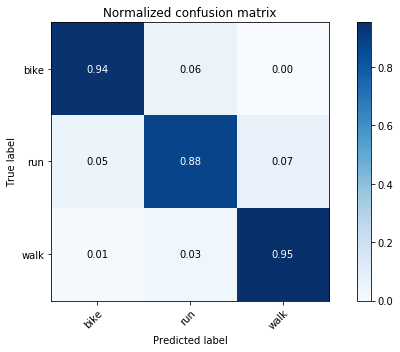

In [15]:
cm = activity_classifier_utils.LOSOCVPerformance(X, labels, subjects, clf)
activity_classifier_utils.PlotConfusionMatrix(cm, class_names, normalize=True)
print('Classification accuracy = {:0.2f}'.format(np.sum(np.diag(cm)) / np.sum(np.sum(cm))))

We no longer misclassify `bike` as `walk`. We've improved our classifier performance by 15%, just by picking the most important features! 